In [ ]:
#data collection
#RAE
import keras
from keras import backend as K
from keras.utils import Sequence
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives
from keras import regularizers
from sklearn.linear_model import Lasso

import numpy as np
import scipy.io
np.set_printoptions(precision = 2, suppress = True)
import os
import nibabel as nib
import pandas as pd
from nibabel import cifti2 as ci
from scipy import stats

path = "/home/qing/Documents/tfMRI_Language_preproc/"
dirs = os.listdir(path)

a = np.memmap('sub_LANGUAGE.mymemmap', dtype = 'float32', mode='w+', shape=(316*791,59421))
del a
sub = np.memmap('sub_LANGUAGE.mymemmap', dtype='float32', mode='r+', shape=(316*791,59421))
sub_data = np.memmap('sub_LANGUAGE.mymemmap', dtype='float32', mode='r+', shape=(316*791,59421))

for num1 in range(0,791):
    sub_path =  path + dirs[num1] + "/tfMRI_LANGUAGE_LR_Atlas_MSMAll.dtseries.nii"
    img = nib.load(sub_path)
    img = img.get_data()
    
    img = img[:,0:59421]
    sub[num1*316:(num1+1)*316, ] = img





In [ ]:
### zscore y#####
import numpy as np
sub = np.memmap('sub_LANGUAGE.mymemmap', dtype='float32', mode='r+', shape=(316*791,59421))

sub_data = np.memmap('sub_LANGUAGE.mymemmap', dtype='float32', mode='r+', shape=(316*791,59421))
import matplotlib.pyplot as plt
from scipy import stats
from numpy import *
print(np.shape(sub))
img_step = 315 #volumeLength-1
cnt = 0
for num2 in range(0,791*(img_step+1)):
    cnt += 1
    if cnt == (img_step + 1):
        cnt = 0
        sub_data[num2 - img_step: num2 + 1,:] = stats.zscore(sub[num2 - img_step: num2 + 1,:])
        


In [ ]:
# many to many ##########
#RAE
import keras
from keras import backend as K
from keras.models import Sequential, Model
from tensorflow.contrib.keras import layers
from keras.layers import Input, LSTM, RepeatVector
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives
from keras import regularizers
from sklearn.linear_model import Lasso
# sub_data = np.memmap('sub_LANGUAGE.mymemmap', dtype='float32', mode='r+', shape=(316*400,59421))
print(sub_data)
sub_data1 = sub_data[0:791*(img_step+1),:]
print(np.shape(sub_data1))
data = np.expand_dims(sub_data1, axis=1)
data = np.reshape(data, (791,316 , 59421))
# latent_dim = [320]

input_dim = data.shape[-1] # 13
timesteps =  data.shape[1]# 3

inputs = Input(shape=(timesteps, input_dim,))
layer1 = Dense(128, activation='tanh',activity_regularizer=regularizers.l1(1*10e-7), kernel_regularizer=regularizers.l2(1*10e-4))#, activity_regularizer=regularizers.l1(1*10e-7), kernel_regularizer=regularizers.l2(1*10e-4)
encoded = layer1(inputs)
encoded = LSTM(64,return_sequences=True,activity_regularizer=regularizers.l1(1*10e-7), kernel_regularizer=regularizers.l2(1*10e-4))(encoded)#
encoded = LSTM(32,return_sequences=True,activity_regularizer=regularizers.l1(1*10e-7), kernel_regularizer=regularizers.l2(1*10e-4))(encoded)#, activity_regularizer=regularizers.l1(1*10e-7), kernel_regularizer=regularizers.l2(1*10e-4)

encoder = Model(inputs, encoded)
encoder.summary()

inputs = Input(shape=(timesteps, 32,))
decoded = LSTM(64, return_sequences=True,activation='tanh')(inputs)
decoded = LSTM(128, return_sequences=True,activation='tanh')(decoded)
outputs = Dense(input_dim, activation='tanh')(decoded)


decoder = Model(inputs, outputs)
decoder.summary()
# model for RAE
inputs = Input(shape=(timesteps, input_dim,))
outputs = encoder(inputs)
outputs = decoder(outputs)
sequence_autoencoder = Model(inputs, outputs)


sequence_autoencoder.compile(optimizer='adam', loss='mse')
sequence_autoencoder.summary()
sequence_autoencoder.fit(data, data, epochs=10, batch_size =1)



In [ ]:
#### predict hidden layer ###

y = np.zeros((791,316,32), dtype=float)
for i in range(0,791):
    y[i * 1 : (i + 1) * 1]=encoder.predict(data[i * 1 : (i + 1) * 1])
    
print(y)

In [ ]:
### zscore y#####
import matplotlib.pyplot as plt
from scipy import stats
from numpy import *
print(y.shape)
y = np.reshape(y, (791*316, 1, 32))
t = range(0, 316)
plt.plot(t, y[316*0: 316*1, 0,1])
y_norm = np.zeros((316*791, 1,32), dtype=float)
img_step = 315
cnt = 0
for num2 in range(np.shape(y)[0]):
    cnt += 1
    if cnt == (img_step + 1):
        cnt = 0
        y_norm[num2 - img_step: num2 + 1,:] = stats.zscore(y[num2 - img_step : num2 + 1,:])
        

where_are_NaNs = isnan(y_norm)
y_norm[where_are_NaNs] = 0
plt.plot(t, y_norm[316*0: 316*1, 0,1])

In [ ]:
###plot task_cope and y_norm#####
import scipy.io as sio
t = range(0, 316)
task = sio.loadmat('/home/qing/Documents/HCP_Label/LANGUAGE_label.mat')
task_content = task['Label']

plt.plot(t,task_content[:,0])

plt.plot(t, y_norm[316*4:316*5, 0,14])##0##for new, there is three dimension
my_y_ticks = np.arange(-2, 3, 1)
plt.yticks(my_y_ticks)
temp = np.corrcoef(task_content[:,1],y_norm[316*4:316*5,0,14])
print('%.3f' % temp[0,1]) 

In [31]:
import scipy.io as sio
sio.savemat('Language_y_norm_20190116.mat', {'y_norm':y_norm})  
  

In [40]:
#### correlation matrix of networks and volumes ###
import numpy as np
import scipy.io as sio
sub_data = np.memmap('sub_LANGUAGE.mymemmap', dtype='float32', mode='r+', shape=(316*791,59421))

task = sio.loadmat('/home/qing/PycharmProjects/RAE/components_img_avg_norm.mat')
components_img_norm = task['components_img_avg_norm']

corr_net = np.zeros((791, 316, 32), dtype=float)
for i in range(4, 5):
    a = sub_data[i * 316 : (i + 1) * 316, :]
    for k in range(0, 316):
        c = a[k, :]
        for j in range(0, 32):
            b = components_img_norm[j, :]
            temp=np.corrcoef(c,b)
            corr_net[i,k,j] = temp[0,1]#i:subnumber k:timepoint of one sub j:networknumber


In [57]:
from scipy import stats
from numpy import *
print(np.shape(corr_net))
corr_net_norm = np.zeros((1,316,32),dtype = float)
# for num2 in range(np.shape(corr_net)[0]):
corr_net_norm[:,:] = stats.zscore(corr_net[549,:])
        


where_are_NaNs= isnan(corr_net_norm)
corr_net_norm[where_are_NaNs] = 0

(791, 316, 32)


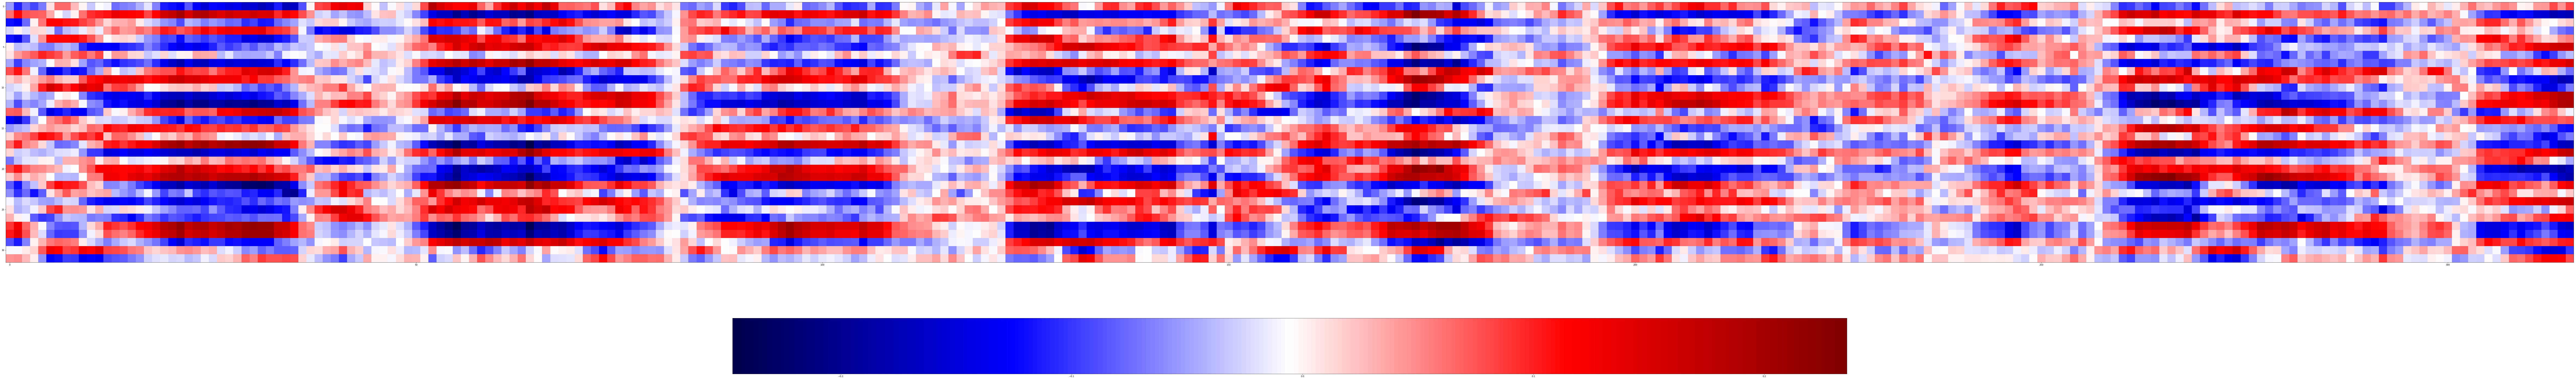

In [74]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(316, 32))
a = np.transpose(corr_net[349,:,:])
im = ax.imshow(a, cmap = 'seismic', interpolation='nearest',origin='upper')
fig.colorbar(im, orientation = 'horizontal')

In [22]:
##### fit networks by ElasticNet ####
from sklearn.linear_model import ElasticNet

y1 = np.squeeze(y_norm)

clf = ElasticNet(alpha=0.7, l1_ratio=0.005)
components_img = np.zeros((791,32, 59421), dtype = float)

for i in range(0,791):
    
    a=y1[i * 316 : (i + 1) * 316, :]
    b=sub_data[i * 316 : (i + 1) * 316, :]
    clf.fit(a, b)
    components_img[i,:,:] = np.transpose(clf.coef_)



In [25]:
components_img_avg = np.zeros((32,59421),dtype = float)
for i in range(0,59421):
    components_img_avg[:,i] = np.mean(components_img[:,:,i],axis = 0)


In [27]:
### zscore y#####
import matplotlib.pyplot as plt
from scipy import stats
from numpy import *
components_img_avg_norm = np.zeros((32,59421),dtype = float)
# print(components_img_GLM.shape)
for num2 in range(0,np.shape(components_img_avg)[0]):
    components_img_avg_norm[num2,:] = stats.zscore(components_img_avg[num2,:])
        


where_are_NaNs= isnan(components_img_avg_norm)
components_img_avg_norm[where_are_NaNs] = 0


In [28]:
import scipy.io as sio
sio.savemat('components_img_avg_norm2.mat', {'components_img_avg_norm':components_img_avg_norm})  
  

In [32]:
#### save patterns####
import nibabel as nib
import pandas as pd
from nibabel import cifti2 as ci


image = nib.load('/home/qing/Documents/tfMRI_Emotion_preproc/100307_3T_tfMRI_EMOTION_preproc/tfMRI_EMOTION_LR_Atlas_MSMAll1.dtseries.nii')
header = image.header
print(header)  
print(np.shape(image.get_data()))
#print(image.nifti_header.get_data_shape())
#image.update_headers()

image_to_write = image.get_data()
image_to_write[:, :] = 0
image_to_write[:32, :59421] = components_img_avg_norm

print(np.shape(image_to_write))
#print(image.nifti_header.get_data_shape())
#print(header)
write_img = ci.Cifti2Image(image_to_write, image.header, image.nifti_header)
nib.save(write_img, 'test_Language_791sub_LSTM_316back_norm_avg2.dtseries.nii')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(176, 91282)
(176, 91282)


In [14]:
from sklearn.linear_model import ElasticNet
import scipy.io as sio
t = range(0, 316)
task = sio.loadmat('/home/qing/Documents/HCP_Label/LANGUAGE_label.mat')
task_content = task['Label']

clf_GLM = ElasticNet(alpha=0.7, l1_ratio=0.005)
components_img_GLM = np.zeros((791,2, 59421), dtype = float)

for i in range(0,791):
    
    a=task_content[:,0:2]
    b=sub_data[i * 316 : (i + 1) * 316, :]
    clf_GLM.fit(a, b)
    components_img_GLM[i,:,:] = np.transpose(clf_GLM.coef_)
 

In [15]:
components_img_GLM_avg = np.zeros((2,59421),dtype = float)
for i in range(0,59421):
    components_img_GLM_avg[:,i] = np.mean(components_img_GLM[:,:,i],axis = 0)
### zscore y#####
import matplotlib.pyplot as plt
from scipy import stats
from numpy import *
components_img_GLM_avg_norm = np.zeros((2,59421),dtype = float)
# print(components_img_GLM.shape)
for num2 in range(0,np.shape(components_img_GLM_avg)[0]):
    components_img_GLM_avg_norm[num2,:] = stats.zscore(components_img_GLM_avg[num2,:])

where_are_NaNs= isnan(components_img_GLM_avg_norm)
components_img_GLM_avg_norm[where_are_NaNs] = 0
import scipy.io as sio
sio.savemat('Language_components_img_GLM_norm.mat', {'components_img_GLM_avg_norm':components_img_GLM_avg_norm})  
  

In [92]:
#calculate the correlation of the GLM with the components
dataFile1 = '/home/qing/PycharmProjects/RAE/components_img_avg_norm.mat'
Language1 = sio.loadmat(dataFile1)
Language1 = Language1['components_img_avg_norm']

dataFile2 = '/home/qing/PycharmProjects/RAE/Language_components_img_GLM_norm.mat'
Language2 = sio.loadmat(dataFile2)
Language2 = Language2['components_img_GLM_avg_norm']

corr_map = np.corrcoef(Language1[11,:],Language2[0,:])
print(corr_map)

[[1.         0.91034937]
 [0.91034937 1.        ]]


In [83]:
####calculate the correlation of two times trials####

import scipy.io as scio
dataFile1 = '/home/qing/PycharmProjects/RAE/components_img_avg_norm.mat'
Language1 = scio.loadmat(dataFile1)
Language1 = Language1['components_img_avg_norm']
# Language1[Language1>0]=1
# Language1[Language1<0]=0
dataFile2 = '/home/qing/PycharmProjects/RAE/components_img_avg_norm2.mat'
Language2 = scio.loadmat(dataFile2)
Language2 = Language2['components_img_avg_norm']
# Language2[Language2>0]=1
# Language2[Language2<0]=0
# Language2[Language1==0]=0

# Language2[Language1==1]=1
# sum_1 = 59421-sum(Language1[8,:])
# sum_2 = 59421-sum(Language2[24,:])
sum_1 = sum(Language1[1,:])
sum_2 = sum(Language2[28,:])
print(sum_2/sum_1)
corr_network = np.corrcoef(Language1[11,:],Language2[14:])
print('%.3f' % corr_network[0,1])

-3.6666666666666665
0.902
